## **Clasificación de Enfermedades en Hojas de Papa (Solanum tuberosum)**

| Aspecto                   | Descripción                                                        |
| ------------------------- | ------------------------------------------------------------------ |
| **Cultivo**               | Papa (*Solanum tuberosum* L.) - 4to alimento básico mundial        |
| **Impacto económico**     | Pérdidas del 20-40% de la cosecha global por enfermedades foliares |
| **Detección tradicional** | Visual por expertos agrónomos - lenta, subjetiva, no escalable     |
| **Solución propuesta**    | Sistema de visión por computadora con deep learning                |


### **Descripción del Problema de Clasificación**

| Código | Clase                   | Descripción patológica | Causa                             |
| ------ | ----------------------- | ---------------------- | --------------------------------- |
| 0      | `Potato___Early_blight` | Tizón temprano         | Hongo *Alternaria solani*         |
| 1      | `Potato___Late_blight`  | Tizón tardío           | Oomyceto *Phytophthora infestans* |
| 2      | `Potato___healthy`      | Hoja sana              | -                                 |




In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import random
import warnings

In [2]:
warnings.filterwarnings('ignore')

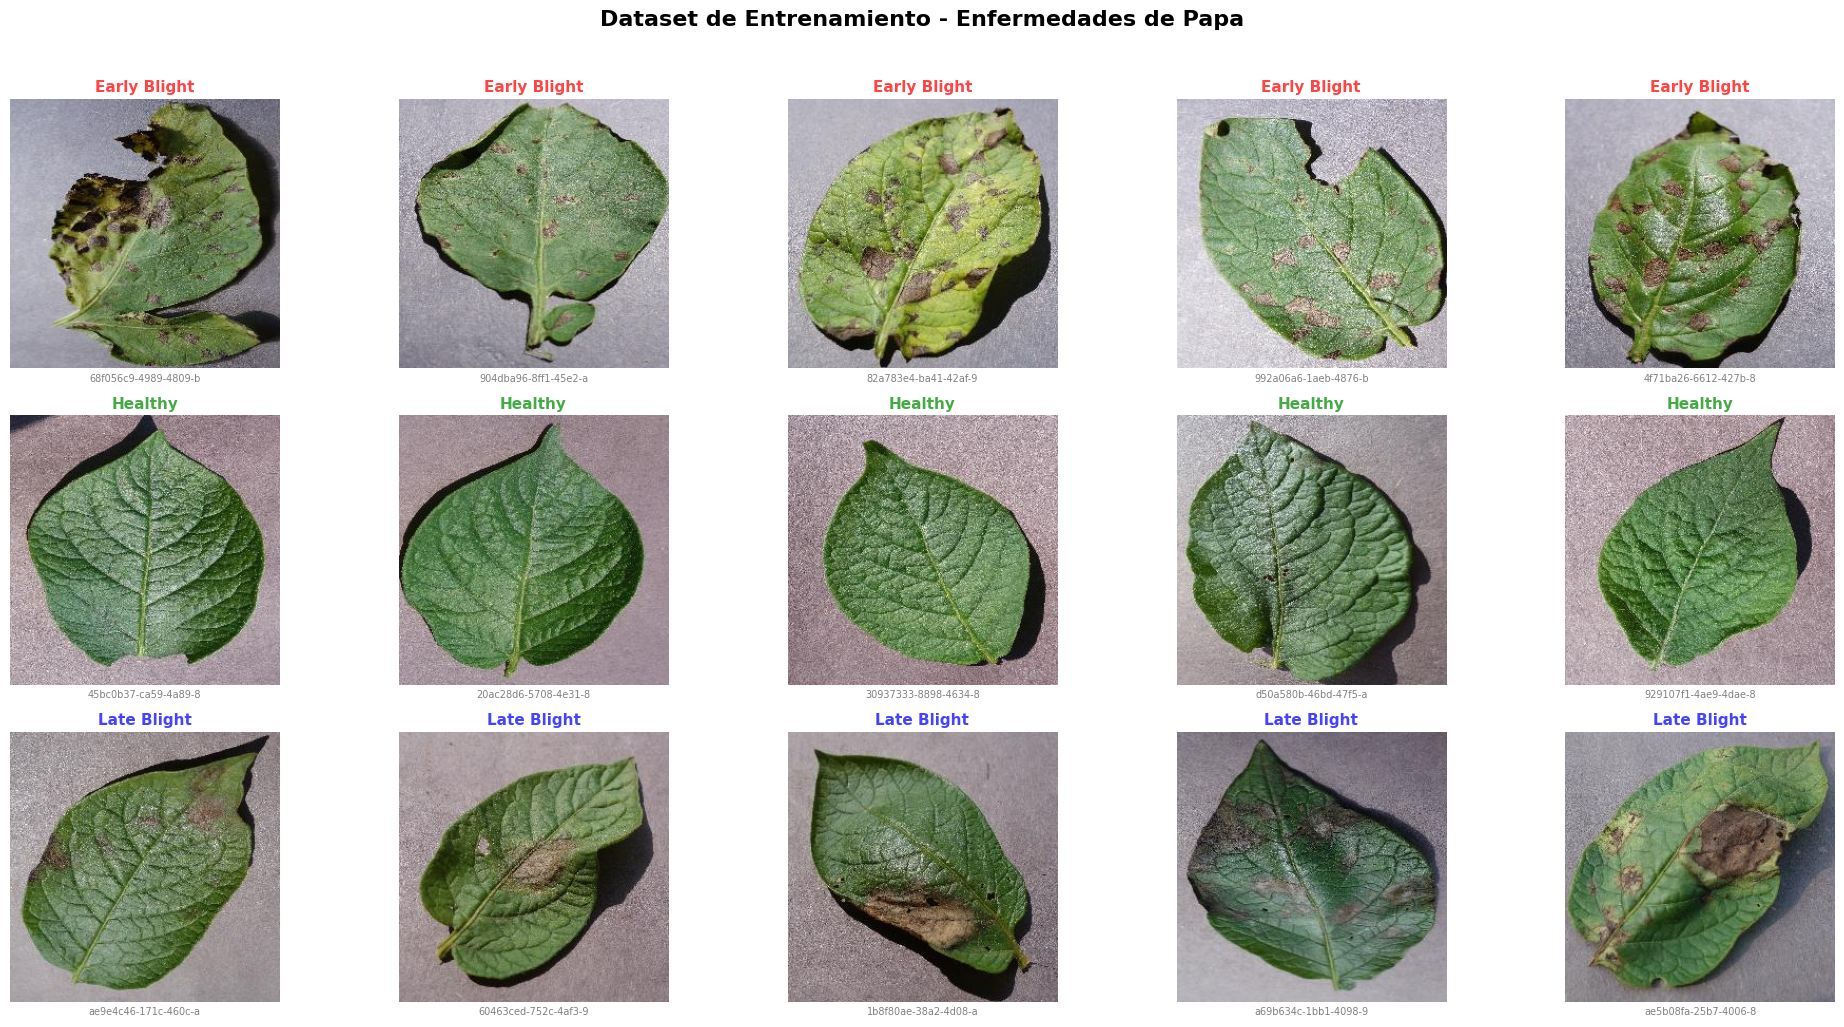

In [3]:

# Tu configuración
TRAIN_DIR = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\train"
CLASES = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# Nombres limpios para mostrar
NOMBRES_LIMPIOS = {
    'Potato___Early_blight': 'Early Blight',
    'Potato___healthy': 'Healthy',
    'Potato___Late_blight': 'Late Blight'
}

# Colores para cada clase
COLORES = {
    'Potato___Early_blight': '#FF4444',  # Rojo
    'Potato___healthy': '#44AA44',       # Verde
    'Potato___Late_blight': '#4444FF'    # Azul
}

# Crear figura
fig, axes = plt.subplots(len(CLASES), 5, figsize=(20, 10))
fig.suptitle('Dataset de Entrenamiento - Enfermedades de Papa', fontsize=16, fontweight='bold', y=1.02)

for i, clase in enumerate(CLASES):
    clase_path = os.path.join(TRAIN_DIR, clase)
    
    if not os.path.exists(clase_path):
        print(f"⚠️ No se encontró: {clase_path}")
        continue
    
    # Obtener imágenes
    imagenes = [f for f in os.listdir(clase_path) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Seleccionar 5 aleatorias
    imagenes_seleccionadas = random.sample(imagenes, min(5, len(imagenes)))
    
    for j, img_name in enumerate(imagenes_seleccionadas):
        img_path = os.path.join(clase_path, img_name)
        img = Image.open(img_path)
        
        # Mostrar imagen
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
        # ✅ TÍTULO CON NOMBRE DE LA CLASE
        nombre_clase = NOMBRES_LIMPIOS[clase]
        axes[i, j].set_title(f'{nombre_clase}', 
                            fontsize=11, 
                            fontweight='bold',
                            color=COLORES[clase],
                            pad=5)
        
        # Subtítulo con nombre de archivo
        axes[i, j].text(0.5, -0.05, img_name[:20], 
                       transform=axes[i, j].transAxes,
                       ha='center', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig('visualizacion_clases.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings

In [6]:
warnings.filterwarnings('ignore')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

## **Función de entrenamiento del modelo**

In [9]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = criterion(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

     #   acc = accuracy(model, val_loader)
        if epoch%1 == 0:
            print(f'Epoch: {epoch}, costo: {cost.item()}')



La función `train()` se encarga de entrenar una red neuronal utilizando un ciclo de aprendizaje supervisado basado en **épocas** y **lotes (batches)** de datos.

Primero, el modelo se envía al dispositivo de cómputo definido (`CPU` o `GPU`) para aprovechar la aceleración por hardware si está disponible. Luego, se ejecuta un ciclo principal que se repite durante el número de épocas especificadas.

En cada época, la función recorre el conjunto de datos de entrenamiento (`train_loader`) por lotes. Para cada lote:

1. Se activa el modo de entrenamiento del modelo con `model.train()`, lo que habilita comportamientos específicos como *dropout* o *batch normalization* en modo entrenamiento.
2. Los datos de entrada (`xi`) y sus etiquetas (`yi`) se transfieren al mismo dispositivo del modelo y se convierten al tipo de dato adecuado.
3. Se realiza la **propagación hacia adelante (forward pass)**, donde el modelo genera predicciones (`scores`).
4. Se calcula la función de pérdida comparando las predicciones con las etiquetas reales.
5. Se reinician los gradientes acumulados del optimizador con `optimiser.zero_grad()`.
6. Se ejecuta la **retropropagación (backward pass)** con `cost.backward()` para calcular los gradientes.
7. El optimizador actualiza los pesos del modelo con `optimiser.step()` para minimizar el error.

Al finalizar cada época, se imprime el valor del costo más reciente para monitorear el progreso del entrenamiento.

Esta función implementa el flujo estándar de entrenamiento en aprendizaje profundo:

**forward → cálculo de pérdida → backward → actualización de pesos**

## **Función de evaluación del modelo**

In [10]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.squeeze().long().to(device)

        preds = model(X_batch)
        predicted = preds.argmax(dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    return all_labels,all_preds 

La función `evaluate()` se utiliza para evaluar el desempeño del modelo sobre un conjunto de datos (por ejemplo, validación o prueba), sin modificar sus pesos. Su objetivo principal es obtener las **predicciones del modelo** y las **etiquetas reales** para analizarlas posteriormente (por ejemplo, calcular accuracy, matriz de confusión, precision, recall, etc.).

Primero, el modelo se pone en **modo evaluación** con `model.eval()`. Esto desactiva comportamientos específicos del entrenamiento como *dropout* y ajusta correctamente capas como *batch normalization*.

Se crean dos listas vacías:
- `all_preds`: almacenará todas las predicciones del modelo.
- `all_labels`: almacenará todas las etiquetas reales.

Luego se utiliza `torch.no_grad()` para desactivar el cálculo de gradientes. Esto:
- Reduce el uso de memoria.
- Acelera la inferencia.
- Evita actualizar los pesos del modelo.

Después, la función recorre los datos por lotes (`loader`):

1. Los datos de entrada y etiquetas se envían al dispositivo de cómputo (`CPU` o `GPU`).
2. Se realiza la **propagación hacia adelante (forward pass)** para obtener las predicciones del modelo.
3. Se selecciona la clase predicha usando `argmax`, que devuelve el índice de la probabilidad más alta.
4. Las predicciones y etiquetas se convierten a formato NumPy y se almacenan en listas globales.

Finalmente, la función devuelve:
- Todas las predicciones del modelo.
- Todas las etiquetas reales.

Esto permite evaluar el rendimiento del modelo de forma completa sobre todo el conjunto de datos.

Si quieres, también puedo darte el markdown para explicar cómo calcular accuracy o la matriz de confusión con lo que devuelve esta función.

## **Visualización de la matriz de confusión**

In [11]:
def plot_confusion_matrix(cm):
  class_labels = train_dataset.class_to_idx
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_labels,
          yticklabels=class_labels)
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.title("Confusion Matrix")
  plt.show()

La función `plot_confusion_matrix(cm)` se encarga de **visualizar gráficamente la matriz de confusión** utilizando un mapa de calor (*heatmap*). Esto facilita interpretar el desempeño del modelo de clasificación.

In [12]:
train_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\train"
test_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\test"
val_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\val"

## **Transformaciones de imágenes para entrenamiento y validación**

In [13]:

train_transforms = transforms.Compose([
    transforms.Resize(256),           # Mantiene aspect ratio
    transforms.RandomCrop(224),       # Crop aleatorio (data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.3,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize(256),           # Mismo resize
    transforms.CenterCrop(224),       # Crop central FIJO (no random)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])



Estas transformaciones incluyen **aumentación de datos** (*data augmentation*) para mejorar la robustez del modelo y reducir el sobreajuste.

##### 1. `Resize(256)`
Redimensiona la imagen manteniendo la proporción original hasta que el lado más corto sea 256 píxeles.

##### 2. `RandomCrop(224)`
Recorta aleatoriamente una región de 224×224 píxeles.  
Esto permite que el modelo vea diferentes partes de la imagen en cada época.

##### 3. `RandomHorizontalFlip(p=0.5)`
Voltea la imagen horizontalmente con probabilidad del 50%.  
Simula variaciones naturales en la orientación.

##### 4. `RandomRotation(30)`
Rota la imagen aleatoriamente hasta ±30 grados.  
Hace al modelo más robusto a cambios de inclinación.

##### 5. `ColorJitter`
Modifica aleatoriamente propiedades visuales:

- `brightness=0.4` → brillo
- `contrast=0.4` → contraste
- `saturation=0.3` → saturación
- `hue=0.1` → tono

Esto simula variaciones de iluminación y condiciones de captura.

##### 6. `ToTensor()`
Convierte la imagen a tensor PyTorch y escala los valores de píxeles a rango [0, 1].

##### 7. `Normalize(mean, std)`
Normaliza los canales RGB usando medias y desviaciones estándar típicas de modelos preentrenados:

- mean = `[0.485, 0.456, 0.406]`
- std = `[0.229, 0.224, 0.225]`

Esto acelera el entrenamiento y mejora la estabilidad.

In [14]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_transforms)
val_dataset = ImageFolder(root=val_dir,transform=val_transforms)

In [15]:
from collections import Counter

def contar_clases(dataset):
    """
    Cuenta imágenes por clase en un Dataset de PyTorch.
    """
    # Extraer todas las etiquetas
    labels = [label for _, label in dataset]
    
    # Contar ocurrencias
    conteo = Counter(labels)
    
    # Mapear a nombres de clases si están disponibles
    if hasattr(dataset, 'classes'):
        print("Distribución de clases:")
        for idx, nombre in enumerate(dataset.classes):
            cantidad = conteo[idx]
            porcentaje = 100 * cantidad / len(labels)
            print(f"  {idx}: {nombre:25s} → {cantidad:4d} imágenes ({porcentaje:.1f}%)")
    else:
        print("Conteo por índice:", dict(conteo))
    
    return conteo

In [15]:
contar_clases(train_dataset)

Distribución de clases:
  0: Potato___Early_blight     →  800 imágenes (46.5%)
  1: Potato___Late_blight      →  800 imágenes (46.5%)
  2: Potato___healthy          →  121 imágenes (7.0%)


Counter({0: 800, 1: 800, 2: 121})

In [16]:
contar_clases(test_dataset)

Distribución de clases:
  0: Potato___Early_blight     →  100 imágenes (46.3%)
  1: Potato___Late_blight      →  100 imágenes (46.3%)
  2: Potato___healthy          →   16 imágenes (7.4%)


Counter({0: 100, 1: 100, 2: 16})

In [17]:
contar_clases(val_dataset)

Distribución de clases:
  0: Potato___Early_blight     →   99 imágenes (46.3%)
  1: Potato___Late_blight      →  100 imágenes (46.7%)
  2: Potato___healthy          →   15 imágenes (7.0%)


Counter({1: 100, 0: 99, 2: 15})

In [16]:
conteo = {0: 999, 1: 1000, 2: 152}
total = sum(conteo.values())

# Calcular pesos inversos: total / cantidad
# Clase con menos muestras → peso mayor
pesos = torch.tensor([
    total / (3 * conteo[0]),   # Early:  2151 / (3*999)  = 0.72
    total / (3 * conteo[1]),   # Late:   2151 / (3*1000) = 0.72
    total / (3 * conteo[2])    # Healthy: 2151 / (3*152) = 4.72
], dtype=torch.float32)


In [17]:
pesos

tensor([0.7177, 0.7170, 4.7171])

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
train_dataset.class_to_idx

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

## **Arquitectura de la Red Neuronal Convolucional (CNN)**

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),


            
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



El modelo implementado es una **red neuronal convolucional profunda** diseñada para la clasificación de imágenes en 3 clases.  
Está compuesta por dos bloques principales:

1. Extractor de características (`features`)
2. Clasificador (`classifier`)

La red aprende patrones visuales progresivamente y luego utiliza esa información para predecir la clase de la imagen.


## **Configuración del Modelo, Función de Pérdida y Optimizador**

In [20]:
# Conteo de tus clases
conteo = {0: 999, 1: 1000, 2: 152}
total = sum(conteo.values())

# Calcular pesos inversos: total / cantidad
# Clase con menos muestras → peso mayor
pesos = torch.tensor([
    total / (3 * conteo[0]),   # Early:  2151 / (3*999)  = 0.72
    total / (3 * conteo[1]),   # Late:   2151 / (3*1000) = 0.72
    total / (3 * conteo[2])    # Healthy: 2151 / (3*152) = 4.72
], dtype=torch.float32)

In [21]:
pesos

tensor([0.7177, 0.7170, 4.7171])

In [30]:
model = CNN()
criterion = nn.CrossEntropyLoss(weight=pesos.to(device))  # para clasificación
optimizer = optim.Adam(model.parameters(), lr=0.0001)

En esta sección se inicializan los componentes fundamentales para el entrenamiento de la red neuronal:

1. El modelo
2. La función de pérdida
3. El optimizador

La función de pérdida mide qué tan equivocadas son las predicciones del modelo.

Se utiliza **CrossEntropyLoss** porque el problema es de clasificación multiclase.

Esta función:

* Recibe los logits del modelo (salida sin activar)

* Compara con la clase real

* Calcula un valor numérico de error

* Penaliza predicciones incorrectas

CrossEntropyLoss ya incluye internamente Softmax, por lo que el modelo no debe aplicarlo manualmente en la última capa.

El **optimizador** se encarga de actualizar los pesos del modelo para reducir el error.

Se utiliza el optimizador Adam, uno de los algoritmos más eficientes y estables en deep learning.

In [31]:
train(model,optimizer,30)

Epoch: 0, costo: 1.2596231698989868
Epoch: 1, costo: 0.8624433279037476
Epoch: 2, costo: 0.7514709234237671
Epoch: 3, costo: 0.7804409265518188
Epoch: 4, costo: 0.49193117022514343
Epoch: 5, costo: 0.3439970016479492
Epoch: 6, costo: 0.35244306921958923
Epoch: 7, costo: 0.2860359847545624
Epoch: 8, costo: 0.4996904730796814
Epoch: 9, costo: 0.3404233455657959
Epoch: 10, costo: 0.32656046748161316
Epoch: 11, costo: 0.2985863983631134
Epoch: 12, costo: 0.20878860354423523
Epoch: 13, costo: 0.18532758951187134
Epoch: 14, costo: 0.27139008045196533
Epoch: 15, costo: 0.3076006770133972
Epoch: 16, costo: 0.2736574411392212
Epoch: 17, costo: 0.29175278544425964
Epoch: 18, costo: 0.34042131900787354
Epoch: 19, costo: 0.5785549283027649
Epoch: 20, costo: 0.21076805889606476
Epoch: 21, costo: 0.06601657718420029
Epoch: 22, costo: 0.12548959255218506
Epoch: 23, costo: 0.11212287843227386
Epoch: 24, costo: 0.16587014496326447
Epoch: 25, costo: 0.14910292625427246
Epoch: 26, costo: 0.21897917985916

In [32]:
labels_train,preds_train = evaluate(model,train_loader)
labels_test,preds_test = evaluate(model,test_loader)
labels_val,preds_val = evaluate(model,val_loader)

In [33]:
cm_train = confusion_matrix(labels_train,preds_train)
cm_test = confusion_matrix(labels_test,preds_test)
cm_val = confusion_matrix(labels_val,preds_val)

## **Evaluación**

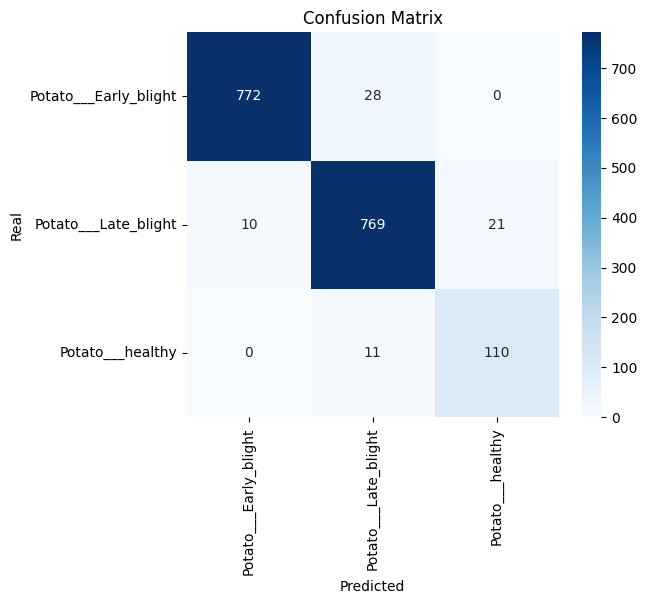

In [34]:
plot_confusion_matrix(cm_train)

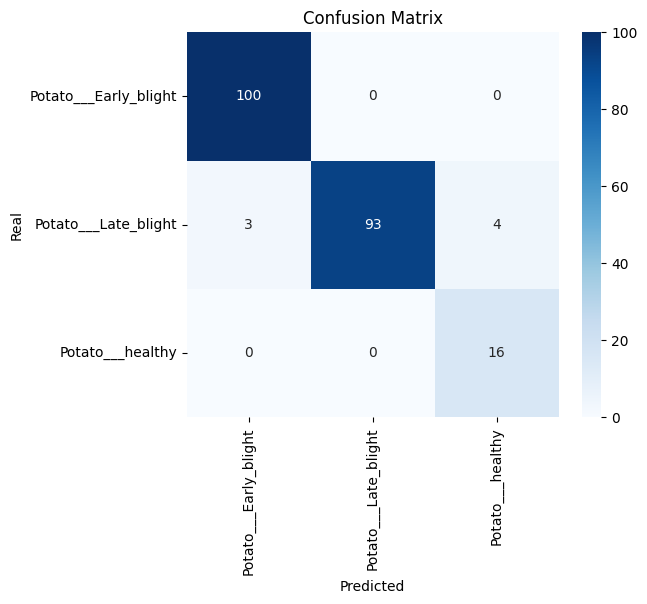

In [35]:
plot_confusion_matrix(cm_test)

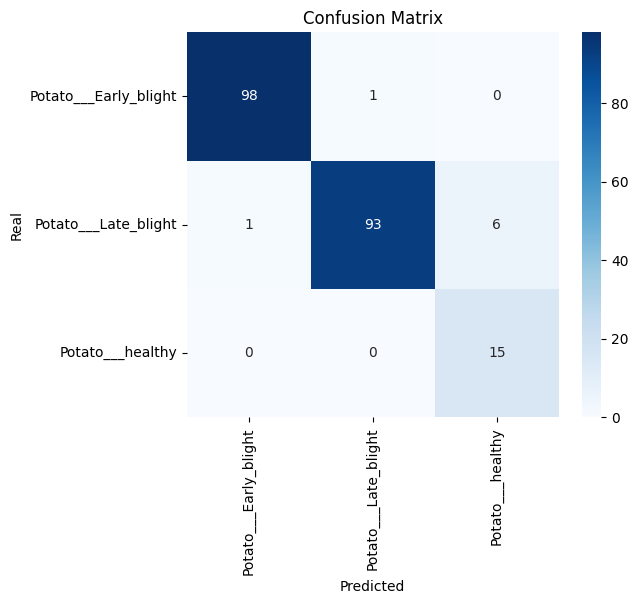

In [36]:
plot_confusion_matrix(cm_val)

In [45]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(labels_test,preds_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.93      0.96       100
           2       0.80      1.00      0.89        16

    accuracy                           0.97       216
   macro avg       0.92      0.98      0.95       216
weighted avg       0.97      0.97      0.97       216



In [50]:
print(classification_report(labels_val,preds_val))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        99
           1       0.99      0.93      0.96       100
           2       0.71      1.00      0.83        15

    accuracy                           0.96       214
   macro avg       0.90      0.97      0.93       214
weighted avg       0.97      0.96      0.96       214



El recall (también llamado sensibilidad o tasa de verdaderos positivos) mide la capacidad del modelo para identificar correctamente todos los casos reales de una clase específica. En otras palabras, indica qué proporción de los ejemplos que realmente pertenecen a una clase fueron detectados correctamente por el modelo.

Se calcula como:

Recall = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)

Un recall alto significa que el modelo casi no deja pasar casos reales sin detectar. Por ejemplo, si una enfermedad tiene recall = 1.00, significa que el modelo encontró todos los ejemplos reales de esa enfermedad y no omitió ninguno.

En contextos como la detección de enfermedades en cultivos, el recall es muy importante porque un falso negativo implica no detectar una planta enferma. En muchos sistemas agrícolas o médicos, es preferible tener un recall alto aunque existan algunos falsos positivos, ya que es más seguro detectar posibles problemas que pasarlos por alto.

En resumen, el recall responde a la pregunta: “De todos los casos reales de esta clase, ¿cuántos logró identificar el modelo correctamente?”.

**Por qué la precisión es más baja en la clase minoritaria**

La precisión de la clase minoritaria puede verse reducida principalmente porque el número total de ejemplos reales de esa clase es pequeño. Cuando una clase tiene pocas muestras, incluso un número muy bajo de errores puede afectar de manera significativa el valor de la precisión.

Esto ocurre porque la precisión depende de la proporción entre predicciones correctas y el total de veces que el modelo predijo esa clase. Si el modelo comete algunos falsos positivos —es decir, clasifica incorrectamente ejemplos de otras clases como pertenecientes a la clase minoritaria— esos errores representan una fracción relativamente grande del total de predicciones para esa clase.

En otras palabras, cuando el número de ejemplos reales es reducido, la métrica se vuelve muy sensible a pequeños cambios. Un solo error puede disminuir notablemente la precisión, algo que no sucede con clases que tienen muchos ejemplos, donde el impacto de cada error individual es menor.

Por ello, una precisión más baja en la clase minoritaria no necesariamente indica que el modelo funcione mal, sino que refleja la influencia del desbalance de datos y la alta sensibilidad de la métrica cuando el tamaño de la muestra es pequeño.


In [38]:
from PIL import Image

In [39]:
idx =  {v: k for k, v in train_dataset.class_to_idx.items()}

In [40]:
def mostrar_predicciones(model, data_dir, transforms, device, idx, total_imagenes=15):
    """
    Muestra grid de imágenes con sus predicciones y probabilidades.
    """
    
    # Recolectar todas las imágenes
    todas_imagenes = []
    for clase in os.listdir(data_dir):
        clase_path = os.path.join(data_dir, clase)
        if os.path.isdir(clase_path):
            for img in os.listdir(clase_path):
                if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                    todas_imagenes.append(os.path.join(clase_path, img))
    
    # Seleccionar aleatorias
    seleccionadas = random.sample(todas_imagenes, min(total_imagenes, len(todas_imagenes)))
    
    # Calcular grid (filas x columnas)
    num_cols = 5
    num_rows = (len(seleccionadas) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*3))
    axes = axes.flatten() if num_rows > 1 else [axes] if num_cols == 1 else axes
    
  
    
    for i, img_path in enumerate(seleccionadas):
        # Cargar y predecir
        img = Image.open(img_path).convert("RGB")
        x = val_transforms(img).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            probs = torch.softmax(model(x), dim=1)[0].cpu().numpy()
            pred_idx = int(np.argmax(probs))
            pred_clase = idx[pred_idx]
            confidence = probs[pred_idx] * 100
        
        # Mostrar
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Etiqueta con predicción y probabilidad
        color = '#2ecc71' if confidence > 80 else '#f39c12' if confidence > 50 else '#e74c3c'
        axes[i].set_title(f'{pred_clase}\n{confidence:.1f}%', 
                         fontsize=10, fontweight='bold', color=color, pad=5)
        
        # Nombre de archivo abajo
        axes[i].text(0.5, -0.05, os.path.basename(img_path)[:15], 
                    transform=axes[i].transAxes, ha='center', fontsize=7, color='gray')
    
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Predicciones del Modelo', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

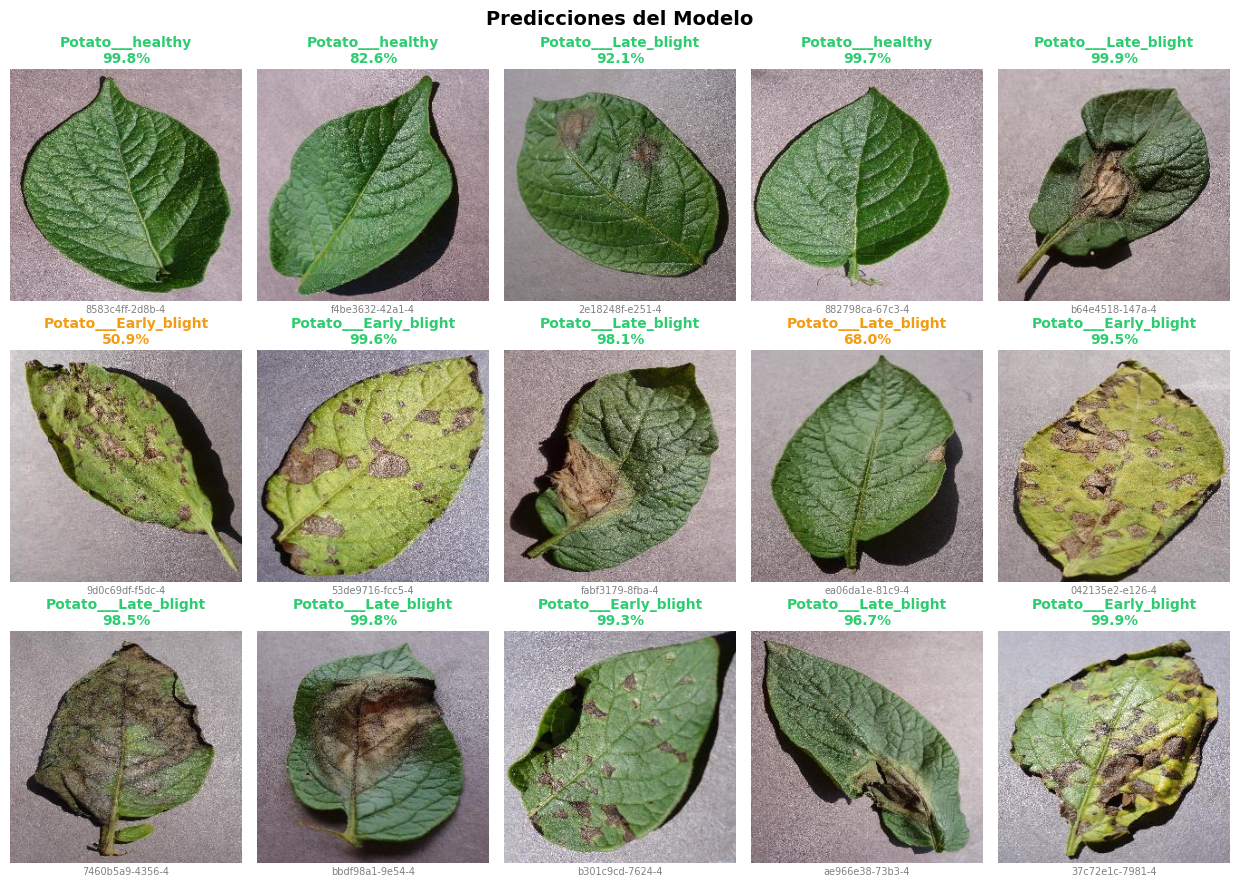

In [41]:
mostrar_predicciones(model, val_dir, transforms, device, idx, total_imagenes=15)

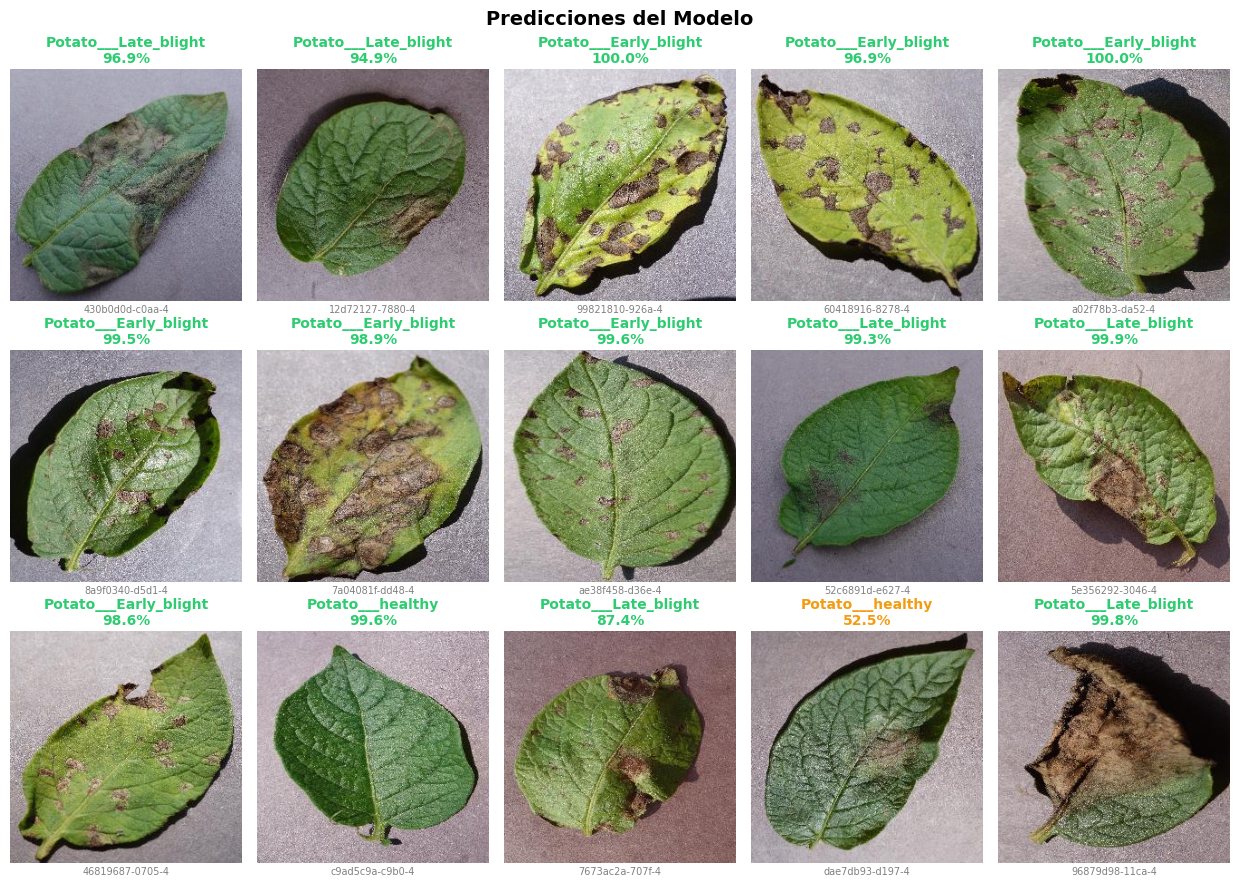

In [42]:
mostrar_predicciones(model, val_dir, transforms, device, idx, total_imagenes=15)

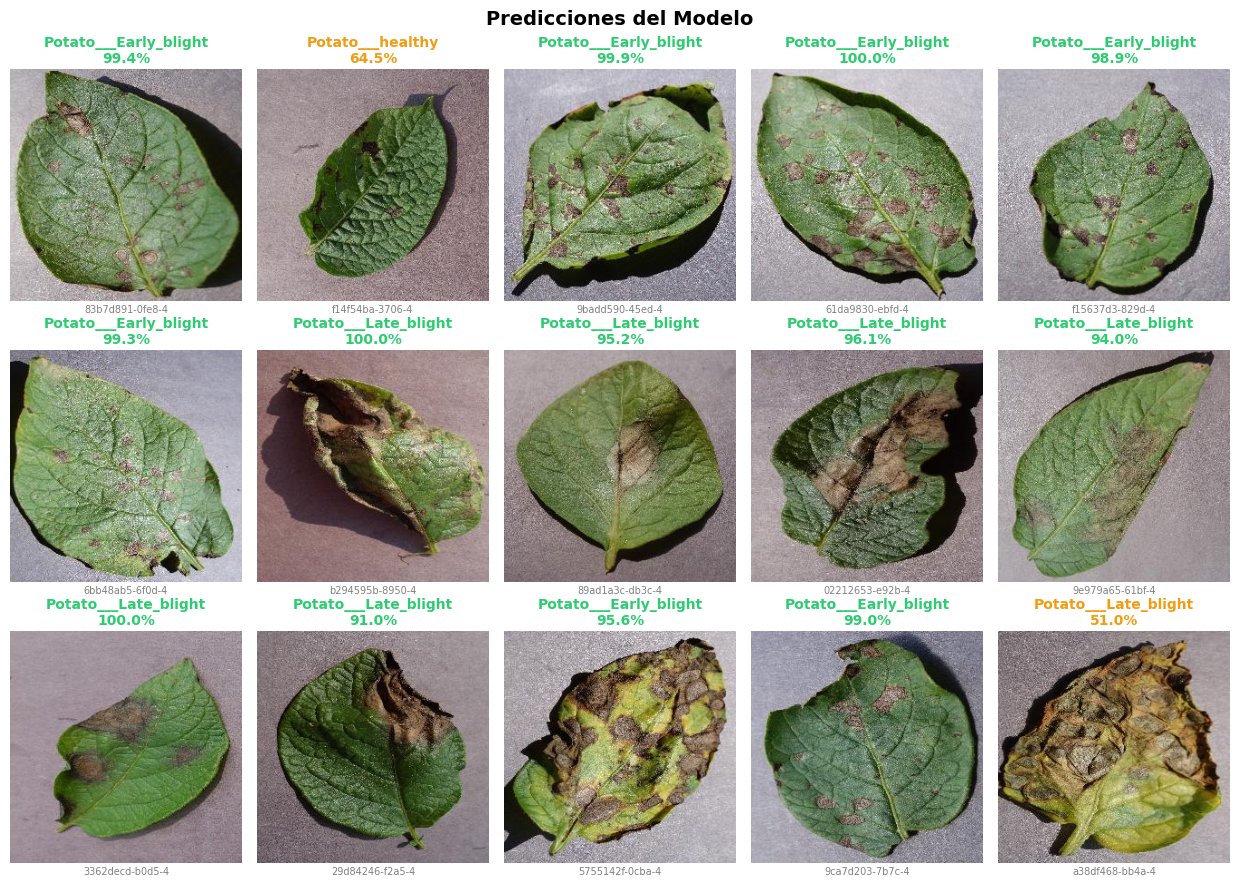

In [43]:
mostrar_predicciones(model, val_dir, transforms, device, idx, total_imagenes=15)

## **Conclusión**

El modelo de red neuronal convolucional desarrollado para la clasificación de enfermedades en hojas de papa demuestra un desempeño sólido y consistente, especialmente considerando la presencia de desbalance entre clases. A partir del análisis de la matriz de confusión, se observa que el modelo logra identificar correctamente la mayoría de las muestras, mostrando un rendimiento sobresaliente en las clases mejor definidas y una capacidad adecuada para detectar la clase minoritaria.

La incorporación de ponderación de clases durante el entrenamiento permitió reducir el sesgo hacia las clases mayoritarias, favoreciendo la detección de enfermedades menos representadas en el conjunto de datos. Como consecuencia, el modelo prioriza la sensibilidad hacia estas clases, lo que puede generar una ligera disminución en la precisión global, pero mejora significativamente la capacidad de detección de casos críticos. Este comportamiento es especialmente relevante en aplicaciones agrícolas, donde la identificación temprana de enfermedades permite prevenir su propagación y reducir pérdidas productivas.

El conjunto de datos utilizado proviene del dataset PlantVillage disponible en Kaggle, el cual fue recolectado bajo condiciones controladas y siguiendo un protocolo riguroso de adquisición de imágenes. Si bien esta estandarización mejora la calidad y consistencia de los datos, también implica que el modelo puede volverse sensible a características del entorno de captura, como el fondo uniforme de las imágenes. En consecuencia, el rendimiento del modelo podría variar al aplicarse en condiciones reales de campo, donde la iluminación, el ruido visual y la variabilidad del fondo son mayores.

Asimismo, la separación independiente de los conjuntos de entrenamiento, validación y prueba permitió evaluar de forma confiable la capacidad de generalización del modelo, evidenciando un comportamiento estable fuera de los datos de entrenamiento.

En conjunto, los resultados indican que el modelo no solo aprende patrones relevantes de las enfermedades de la papa, sino que también maneja adecuadamente el desbalance de clases, lo que lo convierte en una herramienta potencialmente útil para sistemas automatizados de monitoreo fitosanitario y apoyo en la toma de decisiones agrícolas. Sin embargo, para su implementación en escenarios reales, es recomendable entrenarlo con imágenes más diversas en cuanto a fondo y condiciones ambientales, con el fin de mejorar su robustez y capacidad de generalización.

En trabajos futuros, el desempeño podría mejorarse mediante el incremento del conjunto de datos en condiciones reales de campo, técnicas adicionales de aumento de datos específicas por enfermedad, o el uso de modelos preentrenados de mayor capacidad.

In [51]:
torch.save(model.state_dict(), 'modelo_enfermades_papa.pth')   